In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
from random import choices
from random import sample
import warnings
warnings.filterwarnings('ignore')
w = np.array([0.1, 0.1, 0.4, 0.2, 0.2])
Gamma = np.array([[0.62, 0.22, 0.1, 0.04, 0.02], 
          [0.28, 0.63, 0.09, 0.01, 0.01],
          [0.05, 0.16, 0.58, 0.14, 0.07],
          [0.02, 0.06, 0.15, 0.61, 0.16],
          [0.01, 0.06, 0.02, 0.27, 0.64]])
Gamma_shirking = np.array([[0.34, 0.26, 0.26, 0.08, 0.06], 
                            [0.24, 0.33, 0.27, 0.11, 0.05],
                            [0.1, 0.24, 0.28, 0.26, 0.12],
                            [0.06, 0.13, 0.28, 0.3, 0.23],
                            [0.1, 0.07, 0.21, 0.29, 0.33]])

In [7]:
class Crowdsourcing:
    def __init__(self, w, Gamma_w, Gamma_s, 
                       e = 1,
                       m = 100, 
                       n0 = 10, 
                       mi = 30, 
                       prior_e = [0.2, 0.8, 0], 
                       signal = [1,2,3,4,5]):
        self.m = m # Total number of tasks
        self.n0 = n0 # Minimum number of agents that are assigned to each task
        self.mi = mi # Number of tasks that each agent answers
        self.prior_e = prior_e # Prior of three types of agents: shirker, rational worker, honest worker
        self.signal = signal # Signal space
        self.S = len(signal)
        self.w = w # Prior of ground truth
        self.Gamma_w = Gamma_w #Confusion matrix of full effort worker
        self.Gamma_s = Gamma_s #Confusion matrix of shirker
        self.e = e #Effort level of rational agents

def Report_Generator(para):
    m = para.m
    n0 = para.n0
    mi = para.mi
    prior_e = para.prior_e
    w = para.w
    e = para.e
    Gamma_w = para.Gamma_w
    Gamma_s = para.Gamma_s
    signal = para.signal
    n = math.ceil(m*n0/(mi - 1))
    
    agent = np.arange(len(prior_e))
    agent_e = choices(agent, prior_e, k = n)
    Y = choices(list(range(1, len(w)+1)), w, k = m)
    
    flag = 0
    while flag < m:
        flag = 0
        current_task = np.zeros(n)
        R = np.zeros((n, m))
        for j, y in enumerate(Y):
            if len(list(np.where(current_task < mi)[0])) < n0:
                break
            else:
                flag += 1
            random_agents = np.array(sample(list(np.where(current_task < mi)[0]), n0))
            for i, index in enumerate(random_agents):
                if agent_e[index] == 0:
                    Gamma_i = Gamma_s
                elif agent_e[index] == 1:
                    Gamma_i = e*Gamma_w + (1-e)*Gamma_s
                elif agent_e[index] == 2:
                    Gamma_i = Gamma_w
                R[index,j] = choices(signal, Gamma_i[Y[j]-1])[0]
            current_task[random_agents] += 1
    
    agent_i = np.where(np.count_nonzero(R, axis = 1) < mi)[0]
    for i in agent_i:
        if agent_e[index] == 0:
            Gamma_i = Gamma_s
        elif agent_e[index] == 1:
            Gamma_i = e*Gamma_w + (1-e)*Gamma_s
        elif agent_e[index] == 2:
            Gamma_i = Gamma_w
        more_tasks = sample(list(np.where(R[i] == 0)[0]), mi - np.count_nonzero(R[i]))
        for j in more_tasks:
            R[i,j] = choices(signal, Gamma_i[Y[j]-1])[0]

    
    return (R, Y, np.array(agent_e))


def Report_Generator_2(para, E, n_E):
    m = para.m
    n0 = para.n0
    mi = para.mi
    w = para.w
    e = para.e
    Gamma_w = para.Gamma_w
    Gamma_s = para.Gamma_s
    signal = para.signal
    n = np.sum(n_E)
    
    agent = np.arange(len(E))
    agent_e = np.zeros(n)
    for i in range(len(n_E)-1):
        agent_e[np.sum(np.array(n_E)[0:i+1]):np.sum(np.array(n_E)[0:i+2])] = i+1
    Y = choices(list(range(1, len(w)+1)), w, k = m)
    
    flag = 0
    while flag < m:
        flag = 0
        current_task = np.zeros(n)
        R = np.zeros((n, m))
        for j, y in enumerate(Y):
            if len(list(np.where(current_task < mi)[0])) < n0:
                break
            else:
                flag += 1
            random_agents = np.array(sample(list(np.where(current_task < mi)[0]), n0))
            for i, index in enumerate(random_agents):
                e = E[int(agent_e[index])]
                Gamma_i = e*Gamma_w + (1-e)*Gamma_s
                R[index,j] = choices(signal, Gamma_i[Y[j]-1])[0]
            current_task[random_agents] += 1
    
    agent_i = np.where(np.count_nonzero(R, axis = 1) < mi)[0]
    for i, index in enumerate(agent_i):
        if agent_e[index] == 0:
            Gamma_i = Gamma_s
        elif agent_e[index] == 1:
            Gamma_i = e*Gamma_w + (1-e)*Gamma_s
        elif agent_e[index] == 2:
            Gamma_i = Gamma_w
        more_tasks = sample(list(np.where(R[i] == 0)[0]), mi - np.count_nonzero(R[i]))
        for j in more_tasks:
            R[i,j] = choices(signal, Gamma_i[Y[j]-1])[0]

    
    return (R, Y, np.array(agent_e))

In [8]:
"""
Matrix mechanism
"""


def distribution_estimator(X1, X2, para): #learn empirical distributions from two agents' reports
    S = para.S
    X1 = np.array(X1)
    X2 = np.array(X2)
    P = np.zeros((S,S))
    Q1 = np.zeros(S)
    Q2 = np.zeros(S)
    m = len(X1)
    m1 = np.count_nonzero(X1)
    m2 = np.count_nonzero(X2)
    m12 = np.size(np.intersect1d(np.where(X1 != 0), np.where(X2 != 0)))
    
    for i in range(m):
        if X1[i] != 0 and X2[i] != 0:
            P[int(X1[i])-1][int(X2[i])-1] += 1/m12
        if X1[i] != 0:
            Q1[int(X1[i])-1] += 1/m1
        if X2[i] != 0:
            Q2[int(X2[i])-1] += 1/m2
    
    return P, Q1, Q2

def soft_predictor_learner(X, para):
    S = para.S
    X = np.array(X)
    m = np.size(X, axis = 1)
    P = []
    for j in range(m):
        pj =  np.zeros(S)
        nj = np.count_nonzero(X[:,j])
        if nj != 0:
            for i in range(S):
                pj[i] = np.count_nonzero(X[:,j] == i+1)/nj     
        P.append(pj)
    return np.array(P)

def distribution_learner(report, predictor, para): #another version of distribution_estimator, which takes a report vector and a soft predictor as inputs
    S = para.S
    r = report
    index_i = np.where(r != 0)[0]
    pre = predictor
    P = np.zeros((S,S))
    for j in index_i:
        P[int(r[j])-1]+=pre[j]/len(index_i)
    Q_a = np.zeros(S)
    for j in range(S):
        Q_a[j] = np.count_nonzero(r == j+1)/len(index_i)
    #Q_p = np.sum(pre, axis = 0)/len(pre)
    #Q = Q_p*Q_a.reshape(-1,1)
    return P, Q_a

def MI_computer(P, Q1, Q2, f): #For matrix mechanism, learn different types of mutual information
    Q = Q2*Q1.reshape(-1, 1)
    
    if f == 0:
        MI = np.sum(np.absolute(P - Q))
    elif f == 1:
        t = P*np.log(P/Q)
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    elif f == 2:
        t = P*(np.square((Q/P)-1))
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    elif f == 3:
        t = P*(np.square(np.sqrt(Q/P)-1))
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    elif f == 4:
        t = P*(np.power((Q/P)-1, 4))
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    elif f == 5:
        t = P*(np.power((Q/P)-1, 6))
        nan_ind = np.isnan(t)
        t[nan_ind] = 0 
        MI = np.sum(t)
    
    return MI

def mechanism_matrix_fast(X, f, para):
    m = para.m
    X = np.array(X)
    n = np.size(X, axis = 0)
    U = np.zeros(n)
    for i in range(n):
        X_ni = np.vstack((X[0:i], X[i+1:n]))
        Pi = soft_predictor_learner(X_ni, para)
        Q_p = np.sum(Pi, axis = 0)/m
        P, Q_a = distribution_learner(X[i], Pi, para)
        U[i] = MI_computer(P, Q_a, Q_p, f)
    return U

def mechanism_matrix(X):
    X = np.array(X)
    n = np.size(X, axis = 0)
    U = np.zeros((n,4))
    for i in range(n):
        lis = list(range(n))
        lis.remove(i)
        for j in lis:
            P, Q1, Q2 = distribution_estimator(X[i], X[j], para)
            U[i] += MI_computer(P, Q1, Q2)/(n-1)
    return U

def mechanism_matrix_gt(X, f, x, para):
    n = np.size(X, axis = 0)
    U = np.zeros(n)
    for i in range(n):
        P, Q1, Q2 = distribution_estimator(X[i], x, para)
        U[i] = MI_computer(P, Q1, Q2, f)
    return U

In [9]:
"""
Determinant mechanism
"""
def distribution_learner_DMI(report, predictor, para):
    S = para.S
    r = report
    index_i = np.where(r != 0)[0]
    pre = predictor
    P = np.zeros((S,S))
    for j in index_i:
        P[int(r[j])-1]+=pre[j]/len(index_i)
    return P

def mechanism_determinant_fast(X, para):
    n = np.size(X, axis = 0)
    mi = np.count_nonzero(X[0])
    U = np.zeros(n)
    for i in range(n):
        X_ni = np.vstack((X[0:i], X[i+1:n]))
        Pi = soft_predictor_learner(X_ni, para)
        Xi_1 = X[i].copy()
        Xi_1[np.where(X[i] != 0)[0][0:int(mi/2)]] = 0
        Xi_2 = X[i].copy()
        Xi_2[np.where(X[i] != 0)[0][int(mi/2):mi]] = 0
        
        P1 = distribution_learner_DMI(Xi_1, Pi, para)
        P2 = distribution_learner_DMI(Xi_2, Pi, para)
        
        U[i] = np.linalg.det(P1)*np.linalg.det(P2)
    return U

def determinant_computer(X1,X2, para):
    S = para.S
    index = np.intersect1d(np.where(X1 != 0), np.where(X2 != 0))
    m12 = len(index)
    P1 = np.zeros((S,S))
    for j in index[0:int(m12/2)]:
        P1[int(X1[j])-1][int(X2[j])-1] += 1/int(m12/2)
    P2 = np.zeros((S,S))
    for j in index[int(m12/2):m12]:
        P1[int(X1[j])-1][int(X2[j])-1] += 1/(m12-int(m12/2))
    return np.linalg.det(P1)*np.linalg.det(P2)

def mechanism_determinant(X):
    n = np.size(X, axis = 0)
    U = np.zeros(n)
    for i in range(n):
        lis = list(range(n))
        lis.remove(i)
        for j in lis:    
            U[i] += determinant_computer(X[i],X[j], para)/(n-1)
    return U

def mechanism_determinant_gt(X, x, para):
    n = np.size(X, axis = 0)
    U = np.zeros(n)
    for i in range(n):
        U[i] = determinant_computer(X[i], x, para)
    return U

In [27]:
"""
Model functions
"""
def cost(x, a):
    b = 1/(1/(1+np.exp(-a))-1/(1+np.exp(-0.1*a)))
    c = 1 - b/(1+np.exp(-a))
    return np.log((x-c)/(b+c-x))/a

def cost_2(x, a):
    return a*np.log((x+1)/(1-x)) + 0.1

def cost_2_derivative(x, a):
    return 2*a/(1-np.power(x,2))

def accuracy_computer_threshold(R, Y, agent_w):
    R = np.array(R)
    R_w = R[np.where(agent_w == 1)[0]]
    m = np.size(Y)
    Y_tilde = np.zeros(m)
    for j in range(m):
        Rj = R_w[:,j]
        if np.count_nonzero(Rj) > 0:
            counts = np.bincount(np.int_(Rj[np.where(Rj != 0)[0]]))
            Y_tilde[j] = np.argmax(counts)
        else:
            Rj = R[:,j]
            counts = np.bincount(np.int_(Rj[np.where(Rj != 0)[0]]))
            Y_tilde[j] = np.argmax(counts)
    # print(Y, Y_tilde)
    acc = np.count_nonzero(Y_tilde == Y)/m
    return acc

def accuracy_computer_weighted(R, Y, weight, para):
    R = np.array(R)
    Y_tilde = weighted_majority_vote(R, weight, para)
    acc = np.count_nonzero(Y_tilde == Y)/m
    return acc

def weighted_majority_vote(R, y, para):
    S = para.S
    m = para.m
    vote = np.zeros((m, S))
    for j in range(m):
        for s in range(1, S+1):
            vote[j,s-1] = np.sum(y[np.where(R[:,j] == s)[0]])
    x = np.argmax(vote, axis = 1) + 1
    return x
        

def iterated_weighted_maj(R_w, R_s, Y, f, k_max, para):
    n_w = np.size(R_w, axis = 0)
    n_s = np.size(R_s, axis = 0)
    y = np.zeros(n_w + n_s)
    x = np.zeros(np.size(R_w, axis = 1))
    R = np.vstack((R_w, R_s))
    if f < 4:
        y_mi = mechanism_matrix_fast(R, f, para)
        y = y_mi - np.min(y_mi)
    elif f == 4:
        y_mi = mechanism_determinant_fast(np.vstack((R_w, R_s)), para)
        y = y_mi - np.min(y_mi)
        
    for k in range(k_max):
        x = weighted_majority_vote(R, y, para)
        if f < 4:
            y_mi = mechanism_matrix_gt(R, f, x, para)
            y = y_mi - np.min(y_mi)
        elif f == 4:
            y_mi = mechanism_determinant_gt(R, x, para)
            y = y_mi - np.min(y_mi)
    
    x = weighted_majority_vote(R, y, para)
    acc = np.count_nonzero(x == Y)/para.m
    t_vs = np.max(y[n_w:n_w+n_s])
    agent_w = np.zeros(n_w+n_s)
    agent_w[y > t_vs] = 1
    return acc, agent_w

In [33]:
para_w = Crowdsourcing(w = w, Gamma_w = Gamma_w, Gamma_s = Gamma_s, e = e, mi = mi, n0 = n0)
R, Y, agent_e = Report_Generator_2(para_w, [0,eff,e], [int(n*para_w.prior_e[0]),n-int(n*para_w.prior_e[0])-1,1])
P = np.zeros((n,5))
P[:,0] = mechanism_matrix_fast(R, 0, para_w)
print(accuracy_computer_weighted(R, Y, (P[:,0]-min(P[:,0]))/(max(P[:,0]-min(P[:,0]))), para_w))
print(accuracy_computer_threshold(R, Y, agent_e))

1.0
1.0


In [ ]:

w = np.array([0.2, 0.25, 0.25, 0.15, 0.15])
Gamma_w = np.array([[0.8, 0.1, 0.04, 0.04, 0.02], 
          [0.1, 0.8, 0.08, 0, 0.02],
          [0.01, 0.08, 0.82, 0.06, 0.03],
          [0, 0, 0.08, 0.85, 0.07],
          [0, 0.01, 0.01, 0.08, 0.9]])
Gamma_s = np.array([[0.26, 0.34, 0.26, 0.08, 0.06], 
                            [0.24, 0.3, 0.3, 0.11, 0.05],
                            [0.1, 0.28, 0.24, 0.26, 0.12],
                            [0.06, 0.13, 0.28, 0.3, 0.23],
                            [0.12, 0.08, 0.22, 0.3, 0.28]])
m = 100
mi = 50
B = 200
Gamma_random = np.ones((5,5))/5
T = 5000
alpha = 5
Acc_goal = 0.98
de = 0.015
n0 = 15
n = math.ceil(m*n0/(mi - 2))
n_s = int(n/5) + 1
Efforts = np.arange(0.3, 1, de)
Thresholds_fraction = np.arange(0.6,0.8,0.1)
Payment_d_step = np.zeros((len(Thresholds_fraction),5,len(Efforts),2))
Payment_d_linear = np.zeros((5,len(Efforts),2))
Payment_d_vs = np.zeros((5,len(Efforts),2))
Acc_step = np.zeros((len(Thresholds_fraction),5,len(Efforts)))
Acc_linear = np.zeros((5,len(Efforts)))
Acc_vs = np.zeros((5,len(Efforts)))
Acc_opt = np.zeros((len(Efforts)))

flag = np.zeros((len(Thresholds_fraction),5))
Payment_diff_step = np.zeros((len(Efforts),len(Thresholds_fraction),5))
Payment_diff_linear = np.zeros((len(Efforts),5))
Payment_diff_vs = np.zeros((len(Efforts),5))
for h, eff in enumerate(Efforts):
    print(eff)
    for j, e in enumerate([eff, eff+de]):
        para_w = Crowdsourcing(w = w, Gamma_w = Gamma_w, Gamma_s = Gamma_s, e = e, mi = mi, n0 = n0)
        para_s = Crowdsourcing(w = w, Gamma_w = Gamma_w, Gamma_s = Gamma_random, prior_e = [1,0,0], mi = mi, n0 = int(n0/5))
        for l in range(T):
            if l%500 == 0:
                print(j,l)
            R, Y, agent_e = Report_Generator_2(para_w, [0,eff,e], [int(n*para_w.prior_e[0]),n-int(n*para_w.prior_e[0])-1,1])
            R_s, _, _ = Report_Generator_2(para_s, [0,eff,e], [n_s,0,0])
            P = np.zeros((n,5))
            P_vs = np.zeros((n+n_s,5))
            for k in [0,3,4]:
                if k < 4:
                    P[:,k] = mechanism_matrix_fast(R, k, para_w)
                    P_vs[:,k] = mechanism_matrix_fast(np.vstack((R, R_s)), k, para_w)
                else: 
                    P[:,k] = mechanism_determinant_fast(R, para_w)
                    P_vs[:,k] = mechanism_determinant_fast(np.vstack((R, R_s)), para_w)
                
          
            if j == 0:
                agent_w_vs = np.zeros((n,5))
                for k in [0,3,4]:
                    Acc_linear[k,h] += accuracy_computer_weighted(R, Y, (P[:,k]-min(P[:,k]))/(max(P[:,k]-min(P[:,k]))), para_w)/T
                    
                    t_vs = np.max(P_vs[n:n+n_s,k])
                    agent_w_vs[:,k][P_vs[0:n,k] >= t_vs] = 1
                    Acc_vs[k,h] += accuracy_computer_threshold(R, Y, agent_w_vs[:,k])/T
                
                for i,t in enumerate(Thresholds_fraction):
                    agent_w_t = np.zeros((n,5))
                    for k in [0,3,4]:
                        agent_w_t[:,k][P[:,k].argsort()[-int(n*t):][::-1]] = 1
                        Acc_step[i,k,h] += accuracy_computer_threshold(R, Y, agent_w_t[:,k])/T
                        
                Acc_opt[h] += accuracy_computer_threshold(R, Y, agent_e)/T
            
            for k in [0,3,4]:
                P_linear = (P[:,k]-min(P[:,k]))/(max(P[:,k]-min(P[:,k])))
                a1 = B/np.sum(P_linear)
                Payment_d_linear[k,h,j] += a1*P_linear[np.where(agent_e == 2)[0][0]]/T
                
                t_vs = np.max(P_vs[n:n+n_s,k])
                n_w = np.count_nonzero(P_vs[0:n,k] >= t_vs)
                if n_w == 0:
                    a1 = 0.1
                else:
                    a1 = (B-(n-n_w)*0.1)/n_w
                if P_vs[np.where(agent_e == 2)[0],k] >= t_vs:
                    Payment_d_vs[k,h,j] += a1/T
                else:
                    Payment_d_vs[k,h,j] += 0.1/T
                        
            for i,t in enumerate(Thresholds_fraction):
                n_w = int(n*t)
                for k in [0,3,4]:
                    a1 = (B-(n-n_w)*0.1)/n_w
                    if np.count_nonzero(agent_e[P[:,k].argsort()[-int(n*t):][::-1]] == 2) == 1:
                        Payment_d_step[i,k,h,j] += a1/T
                    else:
                        Payment_d_step[i,k,h,j] += 0.1/T
              
    print(Acc_opt[h])
    
    for k in [0,3,4]:
        Payment_diff_linear[h,k] = Payment_d_linear[k,h,1] - Payment_d_linear[k,h,0]
        Payment_diff_vs[h,k] = Payment_d_vs[k,h,1] - Payment_d_vs[k,h,0]
        print(Payment_diff_vs[h,k])
    for i in range(len(Thresholds_fraction)):
        for k in [0,3,4]:
            d1 = Payment_d_step[i,k,h,1] - Payment_d_step[i,k,h,0]
            print(d1)
            Payment_diff_step[h,i,k] = d1
            


0.3
0 0
0 500


In [69]:
Utility_diff_step = np.zeros((len(Efforts),len(Thresholds_fraction),5))
c1 = cost_2(Efforts, 5)
c2 = cost_2(Efforts+de, 5)
for i in range(len(Thresholds_fraction)):
    for k in [0,3,4]:
        Utility_diff_step[:,i,k] = Payment_diff_step[:,i,k] - (c2-c1)
        
Utility_diff_linear = np.zeros((len(Efforts),5))
c1 = cost_2(Efforts, 5)
c2 = cost_2(Efforts+de, 5)
for k in [0,3,4]:
    Utility_diff_linear[:,k] = Payment_diff_linear[:,k] - (c2-c1)
    
Utility_diff_vs = np.zeros((len(Efforts),5))
c1 = cost_2(Efforts, 5)
c2 = cost_2(Efforts+de, 5)
for k in [0,3,4]:
    Utility_diff_vs[:,k] = Payment_diff_vs[:,k] - (c2-c1)
        

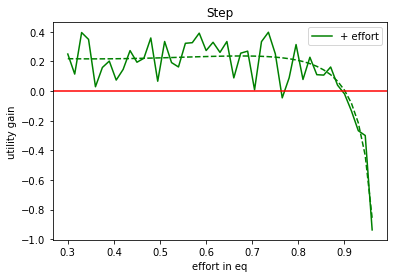

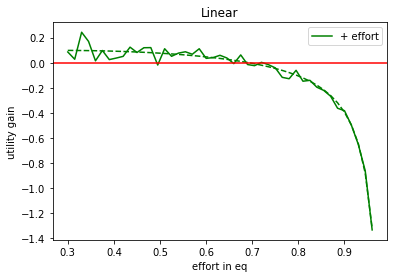

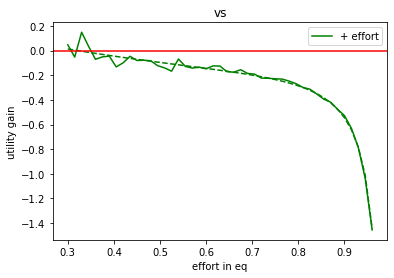

In [89]:
j = 0
k = 0

plt.figure()
index = np.where(np.isnan(Payment_diff_step[:,j,k]) == False)[0]
para = np.polyfit(Efforts[index], Payment_diff_step[index,j,k],2)
plt.plot(Efforts[index[0:-2]], para[0]*np.power(Efforts[index[0:-2]],2)+para[1]*Efforts[index[0:-2]]+para[2] - (c2[index[0:-2]]-c1[index[0:-2]]), 'g--')
plt.plot(Efforts[index[0:-2]], Utility_diff_step[0:-2,j,k], color = 'g', label = '+ effort')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('effort in eq')
plt.ylabel('utility gain')
plt.title('Step')
plt.legend()

plt.figure()
index = np.where(np.isnan(Payment_diff_linear[:,k]) == False)[0]
para = np.polyfit(Efforts[index], Payment_diff_linear[index,k],2)
plt.plot(Efforts[index[0:-2]], para[0]*np.power(Efforts[index[0:-2]],2)+para[1]*Efforts[index[0:-2]]+para[2] - (c2[index[0:-2]]-c1[index[0:-2]]), 'g--')
plt.plot(Efforts[index[0:-2]], Utility_diff_linear[0:-2,k], color = 'g', label = '+ effort')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('effort in eq')
plt.ylabel('utility gain')
plt.title('Linear')
plt.legend()

plt.figure()
index = np.where(np.isnan(Payment_diff_vs[:,k]) == False)[0]
para = np.polyfit(Efforts[index], Payment_diff_vs[index,k],2)
plt.plot(Efforts[index[0:-2]], para[0]*np.power(Efforts[index[0:-2]],2)+para[1]*Efforts[index[0:-2]]+para[2] - (c2[index[0:-2]]-c1[index[0:-2]]), 'g--')
plt.plot(Efforts[index[0:-2]], Utility_diff_vs[0:-2,k], color = 'g', label = '+ effort')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('effort in eq')
plt.ylabel('utility gain')
plt.title('vs')
plt.legend()

In [59]:
from scipy.optimize import fsolve
n = math.ceil(m*n0/(mi - 2))
de = 0.01

Effort_eq_step = np.zeros((len(Thresholds_fraction),5))
Acc_eq_step = np.zeros((len(Thresholds_fraction),5))
flag_step = np.zeros((len(Thresholds_fraction),5))
Effort_eq_linear = np.zeros(5)
Acc_eq_linear = np.zeros(5)
flag_linear = np.zeros(5)
Effort_eq_vs = np.zeros(5)
Acc_eq_vs = np.zeros(5)
flag_vs = np.zeros(5)
for j,t in enumerate(Thresholds_fraction):
    for k in [0,3,4]:
        index = np.where(np.isnan(Payment_diff_step[:,j,k]) == False)[0]
        para = np.polyfit(Efforts[index], Payment_diff_step[index,j,k],2)
        
#         plt.figure()
#         plt.plot(np.arange(0.8,0.99,0.01), para[0]*np.power(np.arange(0.8,0.99,0.01),2)+para[1]*np.arange(0.8,0.99,0.01)+para[2])
#         plt.plot(np.arange(0.8,0.99,0.01), cost_2(np.arange(0.8,0.99,0.01)+de, alpha)-cost_2(np.arange(0.8,0.99,0.01), alpha))
        
        f = lambda t: para[0]*np.power(t,2)+para[1]*t+para[2] - cost_2_derivative(t,alpha)*de
        e0 = fsolve(f, 0.99)[0]
        
        if e0 > 0 and e0 < 1:
            flag_step[j,k] = 1
            Effort_eq_step[j,k] = e0
            i0 = np.where(Efforts < e0)[0][-1]
            i1 = np.where(Efforts >= e0)[0][0]
            
            Acc_eq_step[j,k] = ((e0-Efforts[i0])*Acc_step[j,k,i1] + (Efforts[i1]-e0)*Acc_step[j,k,i0])/(Efforts[i1]-Efforts[i0])

for k in [0,3,4]:
    index = np.where(np.isnan(Payment_diff_linear[:,k]) == False)[0]
    para = np.polyfit(Efforts[index], Payment_diff_linear[index,k],2)
    f = lambda t: para[0]*np.power(t,2)+para[1]*t+para[2] - cost_2_derivative(t,alpha)*de
    e0 = fsolve(f, 0.99)[0]
    if e0 > 0 and e0 < 1:
        flag_linear[k] = 1
        Effort_eq_linear[k] = e0
        i0 = np.where(Efforts < e0)[0][-1]
        i1 = np.where(Efforts >= e0)[0][0]

        Acc_eq_linear[k] = ((e0-Efforts[i0])*Acc_linear[k,i1] + (Efforts[i1]-e0)*Acc_linear[k,i0])/(Efforts[i1]-Efforts[i0])

for k in [0,3,4]:
    index = np.where(np.isnan(Payment_diff_vs[:,k]) == False)[0]
    para = np.polyfit(Efforts[index], Payment_diff_vs[index,k],2)
    f = lambda t: para[0]*np.power(t,2)+para[1]*t+para[2] - cost_2_derivative(t,alpha)*de
    e0 = fsolve(f, 0.99)[0]
    if e0 > 0 and e0 < 1:
        flag_vs[k] = 1
        Effort_eq_vs[k] = e0
        if e0 < Efforts[0]:
            i0 = 0
            i1 = 0
        else:
            i0 = np.where(Efforts < e0)[0][-1]
            i1 = np.where(Efforts >= e0)[0][0]

        Acc_eq_vs[k] = ((e0-Efforts[i0])*Acc_vs[k,i1] + (Efforts[i1]-e0)*Acc_vs[k,i0])/(Efforts[i1]-Efforts[i0])
    
        
print(Acc_eq_step)
print(Acc_eq_linear)
print(Acc_eq_vs)

[[0.99085056 0.         0.         0.9910013  0.98519541]
 [0.98538095 0.         0.         0.97952343 0.94267301]
 [0.83481691 0.         0.         0.79934745 0.89564034]]
[0.95785513 0.         0.         0.99       1.        ]
[0.00014585 0.         0.                nan 0.000186  ]


In [65]:
print(Effort_eq_step)
print(Effort_eq_linear)
print(Effort_eq_vs)

[[0.90708805 0.         0.         0.90846754 0.86075923]
 [0.78554682 0.         0.         0.74656985 0.70156725]
 [0.42464428 0.         0.         0.38743444 0.6099803 ]]
[0.69589135 0.         0.         0.75084695 0.95070763]
[0.32171588 0.         0.         0.25934273 0.76730162]


In [ ]:
"""
Plot smoothened curves
"""
plt.figure()
j = 1
k = 3
index = np.where(np.isnan(Utility_diff[:,j,k,1]) == False)[0]
para = np.polyfit(1/(1-Efforts[index]), Utility_diff[index,j,k,1],1)
plt.plot(Efforts[index], para[0]/(1-Efforts[index])+para[1], 'r--')
plt.plot(Efforts, Utility_diff[:,j,k,1],color = 'r', label = '- effort')

index = np.where(np.isnan(Utility_diff[:,j,k,0]) == False)[0]
para = np.polyfit(-1/(1-Efforts[index]), Utility_diff[index,j,k,0],1)
plt.plot(Efforts[0:-2], -para[0]/(1-Efforts[0:-2])+para[1], 'g--')
plt.plot(Efforts, Utility_diff[:,j,k,0],color = 'g', label = '+ effort')

plt.xlabel('effort in eq')
plt.ylabel('utility gain')
plt.legend()


In [ ]:
"""
Finding equilibrium
"""
from scipy.optimize import fsolve

n = math.ceil(m*n0/(mi - 2))

Effort_eq_step = np.zeros((len(Thresholds_fraction),5))
Payment_eq_step = np.zeros((len(Thresholds_fraction),5))
Prob_work_eq_step = np.zeros((len(Thresholds_fraction),5))
flag = np.zeros((len(Thresholds_fraction),5))
for j,t in enumerate(Thresholds_fraction):
    for k in [1,3,4]:
        index = np.where(np.isnan(Utility_diff[:,j,k,1]) == False)[0]
        para = np.polyfit(1/(1-Efforts[index]), Utility_diff[index,j,k,1],1)
        if para[0]+para[1] >=0:
            e1 = 0
        else:
            f = lambda t: para[0]/(1-t)+para[1]
            e1 = fsolve(f, 0.8)[0]
#         plt.figure()
#         plt.plot(Efforts[index], para[0]/(1-Efforts[index])+para[1])
#         plt.plot(Efforts[index], Utility_diff[index,j,k,1],label = '- effort')

        index = np.where(np.isnan(Utility_diff[:,j,k,0]) == False)[0]
        para = np.polyfit(-1/(1-Efforts[index]), Utility_diff[index,j,k,0],1)
        if para[0]+para[1] <=0:
            e0 = 0
        else:
            f = lambda t: -para[0]/(1-t)+para[1]
            e0 = fsolve(f, 0.8)[0]
#         plt.plot(Efforts[0:-2], -para[0]/(1-Efforts[0:-2])+para[1])
#         plt.plot(Efforts[0:-2], Utility_diff[0:-2,4,4,0],label = '- effort')
        if e0 <= e1 and e0 > 0 and e0 < 1 and Acc[j,k,int((e0-Efforts[0])/0.015)] >= Acc_goal:
            flag[j,k] = 1
            Effort_eq_step[j,k] = e0
            i0 = np.where(Efforts < e0)[0][-1]
            i1 = np.where(Efforts >= e0)[0][0]
            p_w = ((e0-Efforts[i0])*Prob_worker[j,k,i1,1] + (Efforts[i1]-e0)*Prob_worker[j,k,i0,1])/(Efforts[i1]-Efforts[i0])
            Prob_work_eq_step[j,k] = p_w
            n_w = ((e0-Efforts[i0])*Num_worker[j,k,i1] + (Efforts[i1]-e0)*Num_worker[j,k,i0])/(Efforts[i1]-Efforts[i0])
#             Payment_eq_step[j,k] = n_w*(cost_2(e0,alpha)-0.1*(1-p_w))/p_w + (n-n_w)*0.1
            Payment_eq_step[j,k] = n_w*cost_2(e0,alpha)/p_w + (n-n_w)*0.1

effort_opt = Efforts[np.where(Acc_opt >= Acc_goal)[0][0]]
Payment_opt = cost_2(effort_opt, alpha)*n*para_w.prior_e[1] + 0.1*n*para_w.prior_e[0]
    
print('Recall','\n', Prob_work_eq_step)
print('\n','Effort','\n', Effort_eq_step)
print('\n','Payment','\n', Payment_eq_step)
print('\n','Optimal effort/payment', effort_opt, Payment_opt)

[[1. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


IndexError: index 1 is out of bounds for axis 0 with size 1

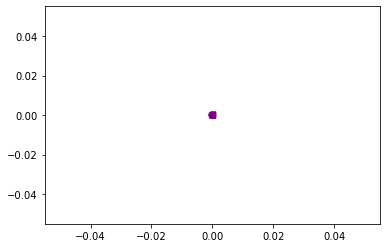

In [53]:
colors = ['gold','goldenrod','darkorange','peru','red','firebrick','purple']
markers = ['o','D','s','<','x','p','h']
MI = ['TVD','KL','Sq','Helg','DMI']
Thresholds = ['10%','20%','30%','40%','50%','60%','70%','80%','90%']
flag = np.zeros((8,5))
flag[np.where(Prob_work_eq_step > 0)] = 1
for i in range(8):
    for k in range(5):
        if flag[i,k] != 0:
            if k == 0:
                plt.scatter(Prob_work_eq_step[i,k], Payment_eq_step[i,k], c = '', edgecolors=colors[i], linewidth=2, marker = markers[k],label=Thresholds[i])
            elif k == 4:
                plt.scatter(Prob_work_eq_step[i,k], Payment_eq_step[i,k], c = colors[i], linewidth=2, marker = markers[k])
            else:
                plt.scatter(Prob_work_eq_step[i,k], Payment_eq_step[i,k], c = '', edgecolors=colors[i], linewidth=2, marker = markers[k])
plt.xlabel('Recall of mechanisms')
plt.ylabel('Payment')
plt.title('mi='+str(mi)+', n0='+str(n0)+', alpha='+str(alpha))
# plt.ylim((0,350))
plt.legend()

effort_opt = Efforts[np.where(Acc_opt >= Acc_goal)[0][0]]
Payment_opt = cost_2(effort_opt, alpha)*n*para_w.prior_e[1] + 0.1*n*para_w.prior_e[0]
plt.axhline(y = Payment_opt, color='b', linestyle='--')